# Max Electron Energy

The purpose of this notebook is to find the highest energy of the electrons fired directly toward the MCP

In [9]:
import numpy as np
from image_analysis_tools import *
from data_analysis_tools import *
import os
import pandas as pd
from importPicture import *
from matplotlib.animation import FuncAnimation
from IPython import display
import matplotlib.pyplot as plt

%matplotlib inline

## Using currents

Extract all the data and put into a single frame

In [202]:
cur_dir = "E:\\EmissionEnergy_Data\\ThressholdExtraction\\currents\\07THz_A_0_V_1490_1370_s2_10\\"

os.chdir(cur_dir)
files = os.listdir()

analysis = AnalysisTools(cur_dir)
data = pd.DataFrame()
for file in files:
    data = data.append(analysis.get_data(file,ret=True))

For each position and each voltage setting the average

In [203]:
data_averaged = pd.DataFrame()
for pos in data.position.unique():
    for voltage in data.voltage_setting.unique():
        current = data.loc[(data.position == pos) & (data.voltage_setting == voltage)].current3.mean()
        data_averaged = data_averaged.append(pd.DataFrame([[pos, voltage, current]], columns=["position","voltage_setting","current"]))

data_averaged = data_averaged.fillna(0)

The background is then subtracted

In [204]:
bright = data_averaged.loc[data_averaged.position == 0]
dark = data_averaged.loc[data_averaged.position == 90]

currents = bright["current"] - dark["current"]
currents = currents.reset_index()

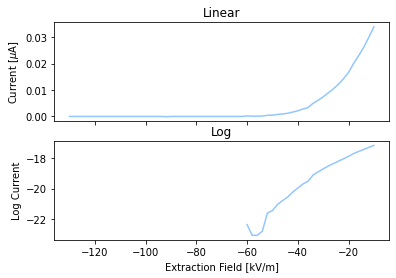

In [205]:
import matplotlib.pyplot as plt

current_values = currents.current.values
voltages = data_averaged.voltage_setting.unique()

voltages = -1500 - voltages

fig, ax = plt.subplots(2, sharex=True)
ax[0].set_title("Linear")
ax[0].plot(voltages, current_values*1e6)
ax[0].set_ylabel(f"Current [$\mu$A]")

ax[1].set_title("Log")
ax[1].set_xlabel("Extraction Field [kV/m]")
ax[1].set_ylabel("Log Current")

filtered_current = current_values[current_values > 0]
filtered_voltage = voltages[current_values > 0]

ax[1].plot(filtered_voltage, np.log(filtered_current))

In [209]:
print("The highest voltage difference at which a current was measured was : ", min(filtered_voltage))

The highest voltage difference at which a current was measured was :  -60


## Using images

### Importing and removing backgrounds

Start by importing and averaging all images with the same name. After this has been done once, we can save the reduced images and load them up later using the path to the reduced images.

All images are stored in an ImageSeries object defined in the image_analysis_tools.py. Its main purpose is to load/save images and put them into CImage structures, also defined in the image_analysis_tools. However, it also contains operations which are applied to all images. E.g. a gaussian filter, median filter, creating image slices relevant for the electron distribution analysis and removing backgrounds.

The CImage can bin, show, slice, and holds the image data in various forms such as numpy, PIL.Image, and log values.

In [54]:
# cur_dir = "E:\\EmissionEnergy_Data\\ThressholdExtraction\\images\\07THz_A_0_V_1490_1370_s2_10\\0\\"
cur_dir = "D:\\OneDrive - Danmarks Tekniske Universitet\\OneDrive\\Dokumenter\\DTU\\Terahertz\\PaperExperiments\\ThresholdData\\images\\07THz_A_0_V_1490_1370_s2_10\\reduced"

images = ImageSeries(others=cur_dir)

Number of settings:  121
Loaded 121 other images


D:\OneDrive - Danmarks Tekniske Universitet\OneDrive\Dokumenter\DTU\Terahertz\PaperExperiments\image_analysis_tools.py:230: RuntimeWarning:

divide by zero encountered in log



Next the reduced images are saved, so we dont have to do the average every time.

Just call the images.save_reduced_set on the path of the save folder.

In [55]:
# reduced_set = "D:\\OneDrive - Danmarks Tekniske Universitet\\OneDrive\\Dokumenter\\DTU\\Terahertz\\PaperExperiments\\ThresholdData\\images\\07THz_A_0_V_1490_1370_s2_10\\reduced"
# images.save_reduced_set(path=reduced_set)

Let's seperate the images with and without power in a front and background dict.

Using the ImageSeries build in background subtracter, which takes a dict, the backgrounds are removed.

In [56]:
backs = {name : images.others[name] for name in images.others_names if "pos_90" in name}
fronts = {name : images.others[name] for name in images.others_names if "pos_0" in name}
images.subtract_backgrounds(backs)

### Filtering

The recorded images are now loaded and seperated into images with data and background measurements. All of them are the average of the number of images done during the measurement with the background subtracted.

During the measurement, it is expected that the final images are far inside the noise floor. However, looking at the last images, sometimes small bright spots appear. These are clearly not physical, but an artifact from the phosphor screen or camera.
In order to remove these, we create a bit mask. This is done by creating a numpy array of ones where the value of the background is above 1.5 times the mean value. And zeroes where it is below 1.5 times the mean background value.


In [64]:
means, stds = 0,0
for name, image in backs.items():
    stds += image.data.std()
    means += image.data.mean()
stds /= len(backs)
means /= len(backs)
print(f"Mean std value for background : {stds}")
print(f"Mean mean value for background : {means}")

Mean std value for background : 0.8379976242022603
Mean mean value for background : 5.925893980545968


As seen above the average standard deviation is much smaller than the average mean of the backgrounds. Having a 1.5 times the mean threshold is then multiple standard deviations, meaning only very high suspicious values are removed.

In case no artefacts appear, these steps should not be conducted, as it could remove intensity caused by actual electrons.
The artefacts should appear sharp and clustered when plotting the mask of the last image.

Lets create a mask where any pixel which breaks the 1.5 mean rule in any image is set to True.

In [93]:
rule_value = 1.5

mask = np.zeros(backs[list(backs)[0]].data.shape, dtype=bool)
for name, image in backs.items():
    im_mean = image.data.mean() * rule_value
    mask[image.data > im_mean] = True
print("Outlier pixels : ", np.sum(mask))
print("Alright pixels : ", np.sum(~mask))
print("Percent of pixels to be removed : ", np.sum(mask)/np.sum(~mask)*100)

Outlier pixels :  18621
Alright pixels :  2800195
Percent of pixels to be removed :  0.6649894025237528


We can plot the mask using matplotlib's imshow. This gives a two colour map of the true and false pixels.

Ideally small islands with sharp edges should appear. There is no "right" answer to the rule value. However, too small means alot of real data might be lost, and too large means a lot of artefacts survive.

Try playing around with it.

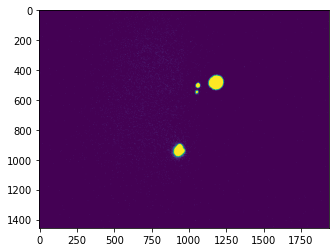

In [94]:
plt.imshow(mask)

The mask can then be applied to the fronts data using the build in function, apply_mask.

The resulting image will be the original with zeros where the mask is True.

In [95]:
for name, im in fronts.items():
    im.apply_mask(mask)

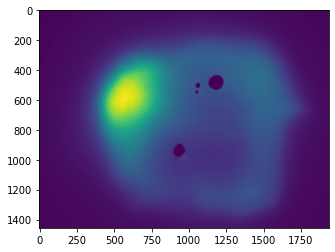

In [102]:
plt.imshow(fronts[list(fronts)[-1]].data)

In some cases the applied filters are not enough. As the imshow scales the image between the highest and lowest values in the image, bight spots not caught by the mask can be found.

The question is then whether it is physical or an artefact.

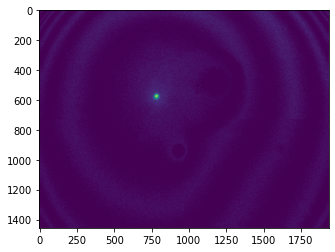

In [118]:
plt.imshow(fronts[list(fronts)[0]].data)

In this specific case the spot only appears in images with THz power ON. It is not at the center of the spot which does not prove it is non physical, but does make for a counter argument.

Lets compare to the image with the least opposing field.

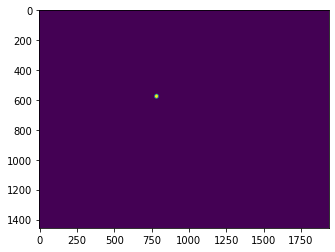

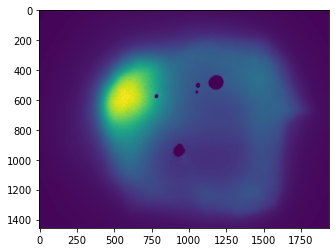

In [152]:
# Create mask and get the first and last image
front_mask = np.zeros(fronts[list(fronts)[0]].data.shape, dtype=bool)
first_image = fronts[list(fronts)[0]].data
back_image = fronts[list(fronts)[-1]].data.copy()

# Set high rule value as the mean is very small
rule_value = 25

# Get the mean and apply the mask
im_mean = first_image.mean() * rule_value
front_mask[first_image > im_mean] = True
back_image[front_mask] = 0

# Plot mask
plt.figure()
plt.imshow(front_mask)

# Plot image with mask
plt.figure()
plt.imshow(back_image)

The fact that the spot is there in all front images and no back images suggests it is physical. However, the intensity of the spot would be expected to change when increasing the opposing voltage.

Below is shown a plot of the maximum pixel value against the voltage on the surface.

When close to 0V the pixel value will be around 250 as the exposure time is set to accomodate this. The lucam API returns an error for exposure times slightly above 900 ms, meaning most measurements were done using the same exposure time.

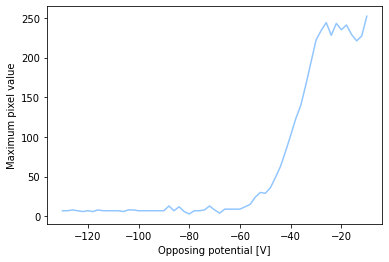

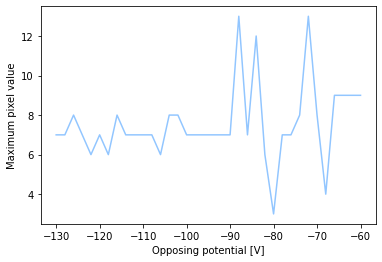

In [162]:
max_vals = []
voltages = [v - 1500 for v in images.voltages]
for name,im in fronts.items():
    max_vals.append(np.max(im.data))

plt.figure()
plt.plot(voltages, max_vals)
plt.xlabel("Opposing potential [V]")
plt.ylabel("Maximum pixel value")

removed = -25
plt.figure()
plt.plot(voltages[:removed], max_vals[:removed])
plt.xlabel("Opposing potential [V]")
plt.ylabel("Maximum pixel value")
plt.show()

The non changing intensityt at high opposing field suggests either that it is non physical or that the energy of the electrons in this single spot, is much larger than the potential barrier they are breaking.

### Summing the images

Multiple methods for evaluating whether electrons reach the MCP exist. 

A simple method is to do the sum of the images and plot them on a log scale. Some of the images are captured using lower exposure times, meaning the values will be smaller than when using the same for all. However, as the eposure time is at its maximum at the field strengths where the noise floor is reached, this is still a valid method.

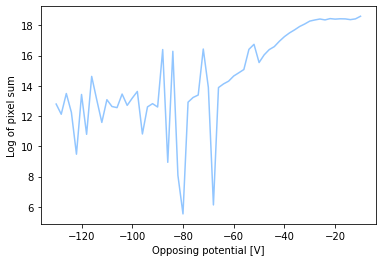

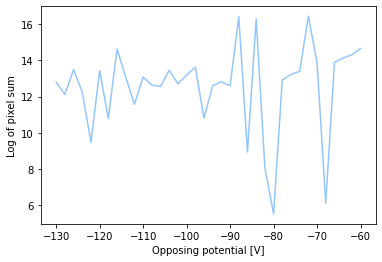

In [171]:
sums = []
voltages = [v - 1500 for v in images.voltages]
for name,im in fronts.items():
    sums.append(np.sum(im.data))

sums_log = np.log(sums)
    
plt.figure()
plt.plot(voltages, sums_log)
plt.xlabel("Opposing potential [V]")
plt.ylabel("Log of pixel sum")

removed = -25
plt.figure()
plt.plot(voltages[:removed], sums_log[:removed])
plt.xlabel("Opposing potential [V]")
plt.ylabel("Log of pixel sum")
plt.show()

The above images show the log of the pixel sums. There is a clear trend of reduced intensity from -10 to -65. Below this the image intensities seem random. Lets plot the intensities below -65 as a histogram.


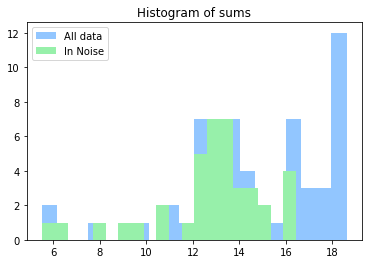

In [200]:
plt.title("Histogram of sums")

removed = -22
plt.hist(sums_log, bins=20, label="All data")
plt.hist(sums_log[:removed], bins=20, label="In Noise")
plt.legend()

plt.show()

We see that all the data has two distributions seperated by about 5 on the log scale.

The green values are the values below -65 V, showing mainly the lower of the distributions.

A noise floor of 13 and a signal of 18 are the expected values. 


The conclusion of the sum analysis is that the noise floor is at around -65 V, which is close to the value found from measuring the current. This suggests the images are slightly more sensitive when measuring with lower power or high potential difference.